### Домашнее задание к уроку 7

Как было сказано ранее, GAN обучается воспроизводить реальные данные. Поэтому Вам предлагается обучить генератор создавать точки, которые будут лежать на графике функции 
 
#### y=sin(x)/x-x/10
 
 При выполнении данного задания структура GAN остается той же, но Вам нужно:
- Сгенерировать настоящие данные
- Изменить архитектуру дискриминатора и генератора
- Без графиков домашку не принимаю

In [1]:
import os
import numpy as np
import math

from torch.utils.data import DataLoader
import torchvision.transforms as transforms
from torchvision import datasets
from torch.autograd import Variable

import torch.nn as nn
import torch

import matplotlib.pyplot as plt
from IPython import display
from torchvision.utils import save_image, make_grid

import matplotlib.patches as mpatches
from matplotlib.pyplot import figure

In [2]:
device = "cpu"

In [3]:
lr = 0.0002

b1 = 0.5
b2 = 0.999

BATCH_SIZE = 256
DATA_SIZE = BATCH_SIZE * 300

MIN_X = -5
MAX_X = 5

hidden_dim = 30

# noise random uniform min and max values
noise_min = -0.5
noise_max = 0.5

n_epochs = 100

<function matplotlib.pyplot.show(close=None, block=None)>

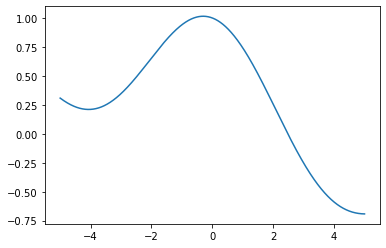

In [4]:
x = np.linspace(MIN_X, MAX_X, 3500)
y = lambda x: ((np.sin(x)/x) - (x/10))

plt.plot(x, y(x))
plt.show

#### Генерируем обучающие данные

In [5]:
x_train = np.linspace(MIN_X, MAX_X, 100500)
np.random.shuffle(x_train)
x_train = x_train[:DATA_SIZE]
y_train = y(x_train)

train_data = np.array([[x_train[i], y_train[i]] for i in range(x_train.shape[0])])
train_data[:10]

array([[ 1.18613121,  0.66285536],
       [ 0.94025811,  0.76500459],
       [ 0.56622454,  0.89079259],
       [ 3.326252  , -0.38782597],
       [ 1.70335028,  0.41159318],
       [-1.10443885,  0.91919126],
       [-3.41411357,  0.26257386],
       [ 0.07945353,  0.99100284],
       [-4.04038846,  0.21035009],
       [ 3.73690285, -0.52375189]])

In [6]:
trainloader = torch.utils.data.DataLoader(train_data, batch_size=BATCH_SIZE,
                                          shuffle=True, num_workers=1)

In [7]:
samples_cnt_data = trainloader.dataset.data.shape[0]
samples_cnt_data

76800

In [8]:
batches_cnt_data = math.ceil(samples_cnt_data / BATCH_SIZE)
batches_cnt_data

300

#### Создаем генератор

In [9]:
class Generator(nn.Module):
    def __init__(self):
        super().__init__()
        
        def block(in_feat, out_feat, normalize=True): #activation='relu
            layers = [nn.Linear(in_feat, out_feat)]
            if normalize:
                layers.append(nn.BatchNorm1d(out_feat, 0.8))
            layers.append(nn.LeakyReLU(0.2, inplace=True))
            return layers

        self.model = nn.Sequential(
            *block(hidden_dim, 128, normalize=False),
            *block(128, 256),
            *block(256, 512),
            *block(512, 1024),
            nn.Linear(1024, 2)
        )

    def forward(self, z):
        img = self.model(z)
        return img

In [10]:
gen_model = Generator().double().to(device)

gen_model.eval()

x = Variable(torch.from_numpy(np.random.uniform(MIN_X, MAX_X, (BATCH_SIZE, hidden_dim)).astype(np.float64)).double()).to(device)

with torch.no_grad():
    test_pred = gen_model(x)

gen_model.train()

Generator(
  (model): Sequential(
    (0): Linear(in_features=30, out_features=128, bias=True)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Linear(in_features=128, out_features=256, bias=True)
    (3): BatchNorm1d(256, eps=0.8, momentum=0.1, affine=True, track_running_stats=True)
    (4): LeakyReLU(negative_slope=0.2, inplace=True)
    (5): Linear(in_features=256, out_features=512, bias=True)
    (6): BatchNorm1d(512, eps=0.8, momentum=0.1, affine=True, track_running_stats=True)
    (7): LeakyReLU(negative_slope=0.2, inplace=True)
    (8): Linear(in_features=512, out_features=1024, bias=True)
    (9): BatchNorm1d(1024, eps=0.8, momentum=0.1, affine=True, track_running_stats=True)
    (10): LeakyReLU(negative_slope=0.2, inplace=True)
    (11): Linear(in_features=1024, out_features=2, bias=True)
  )
)

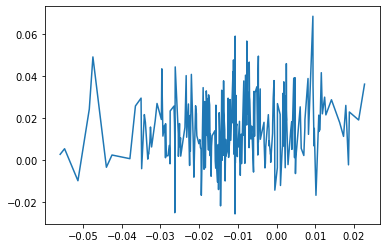

In [11]:
test_pred = test_pred.cpu().detach().numpy()
p = test_pred[:,0].argsort()
plt.plot(test_pred[:,0][p], test_pred[:, 1][p])
plt.show()

#### Создаем дискриминатор

In [12]:
class CustomLinearLayer(nn.Module):
    def __init__(self, size_in, size_out):
        super().__init__()
        self.size_in, self.size_out = size_in, size_out
        
        weights = torch.Tensor(size_out, size_in)
        self.weights = nn.Parameter(weights) 

        bias = torch.Tensor(size_out)
        self.bias = nn.Parameter(bias)

        nn.init.uniform_(self.weights, -0.05, 0.05) 
        nn.init.uniform_(self.bias, -0.05, 0.05)  

    def forward(self, x):
        w_times_x = torch.mm(x, self.weights.t())
        return torch.add(w_times_x, self.bias)  

In [13]:
class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()

        self.model = nn.Sequential(
            CustomLinearLayer(2, 512),
            nn.LeakyReLU(0.2, inplace=True),
            CustomLinearLayer(512, 256),
            nn.LeakyReLU(0.2, inplace=True),
            CustomLinearLayer(256, 1),
            nn.Sigmoid(),
        )
        

    def forward(self, coords):
        coords_flat = coords.view(coords.size(0), -1)
        validity = self.model(coords_flat)

        return validity

In [14]:
discriminator_model = Discriminator().to(device)

#### Затаив дыхание запускаем GAN (Generative Adversarial Network)

In [15]:
optimizer_G = torch.optim.Adam(gen_model.parameters(), lr=lr, betas=(b1, b2))
optimizer_D = torch.optim.Adam(discriminator_model.parameters(), lr=lr, betas=(b1, b2))

adversarial_loss = torch.nn.BCELoss()

In [16]:
%%time

d_loss_history = []
g_loss_history = []

for epoch in range(n_epochs):
    
    generator_epoch_loss = 0.0
    discriminator_epoch_loss = 0.0
    
    for i, data in enumerate(trainloader):
        
        valid = Variable(torch.FloatTensor(BATCH_SIZE, 1).fill_(1.0),requires_grad=False).to(device)
        fake = Variable(torch.FloatTensor(BATCH_SIZE, 1).fill_(0.0), requires_grad=False).to(device)
        real_coords = Variable(data.type(torch.FloatTensor)).to(device)

# Тренировка генератора
        
        optimizer_G.zero_grad()

        z = Variable(
            torch.from_numpy(
                np.random.uniform(
                    noise_min, noise_max, (BATCH_SIZE, hidden_dim)
                ).astype(np.float64)
            ).double()
        ).to(device)

        gen_coords = gen_model(z)

        validity = discriminator_model(gen_coords.float())
        g_loss = adversarial_loss(validity, valid)
        
        g_loss.backward()
        optimizer_G.step()
        
        generator_epoch_loss += g_loss.item()

# Тренировка дискриминатора

        optimizer_D.zero_grad()

        real_pred = discriminator_model(real_coords.float())
        d_real_loss = adversarial_loss(real_pred, valid)

        fake_pred = discriminator_model(gen_coords.detach().float())
        d_fake_loss = adversarial_loss(fake_pred, fake)

        d_loss = (d_real_loss + d_fake_loss) / 2

        d_loss.backward()
        optimizer_D.step()
        
        discriminator_epoch_loss += d_loss.item()

# Вывод значения потерь

        if (i+1) % batches_cnt_data == 0:           
            display.clear_output(wait=False)
            print("[Epoch %d/%d] [D loss: %f] [G loss: %f]"
                  % (epoch+1, n_epochs,
                     discriminator_epoch_loss / batches_cnt_data,
                     generator_epoch_loss / batches_cnt_data)
                 )

[Epoch 100/100] [D loss: 0.687933] [G loss: 0.701420]
Wall time: 26min 38s


In [17]:
gen_model.eval()

xx = Variable(
        torch.from_numpy(
            np.random.uniform(
                noise_min, noise_max, (BATCH_SIZE, hidden_dim)
            ).astype(np.float64)
        ).double()
    ).to(device)

with torch.no_grad():
    test_pred = gen_model(xx)

gen_model.train()

test_pred = test_pred.cpu().detach().numpy()

In [18]:
count = 0
error = 0.0
for i in range(len(test_pred)):
    xxx = test_pred[i][0]
    y_pred = test_pred[i][1]
    y_real = y(xxx)
    print("X: %.10f;\t" % xxx, "y_pred: %.10f;\t\t" % y_pred, "y_real: %.10f" % y_real)
    
    count +=1
    error += abs(y_real - y_pred)

print("\nTotal mean error: %.10f" % (error/count))

X: -2.1953648463;	 y_pred: 0.5643538916;		 y_real: 0.5890493260
X: 4.0458585486;	 y_pred: -0.5925062951;		 y_real: -0.5988515435
X: 1.7221727418;	 y_pred: 0.3915269501;		 y_real: 0.4018043837
X: -4.5426762211;	 y_pred: 0.2283936279;		 y_real: 0.2372956711
X: -4.5603301481;	 y_pred: 0.2299886636;		 y_real: 0.2392808757
X: -0.9656140274;	 y_pred: 0.9325939621;		 y_real: 0.9482457980
X: 0.7031462347;	 y_pred: 0.8433658688;		 y_real: 0.8492961714
X: 0.2605105039;	 y_pred: 0.9537030981;		 y_real: 0.9626763152
X: 0.4297968979;	 y_pred: 0.9194645316;		 y_real: 0.9265158627
X: -2.1864202523;	 y_pred: 0.5698269742;		 y_real: 0.5920438486
X: -1.4541627110;	 y_pred: 0.8053632431;		 y_real: 0.8284251252
X: 2.8482504609;	 y_pred: -0.1847387820;		 y_real: -0.1833054425
X: 4.8503800072;	 y_pred: -0.6695363121;		 y_real: -0.6892476368
X: 3.2811469939;	 y_pred: -0.3722631101;		 y_real: -0.3705089602
X: -2.2607200907;	 y_pred: 0.5465118198;		 y_real: 0.5672440733
X: -3.6094106318;	 y_pred: 0.2160607389;

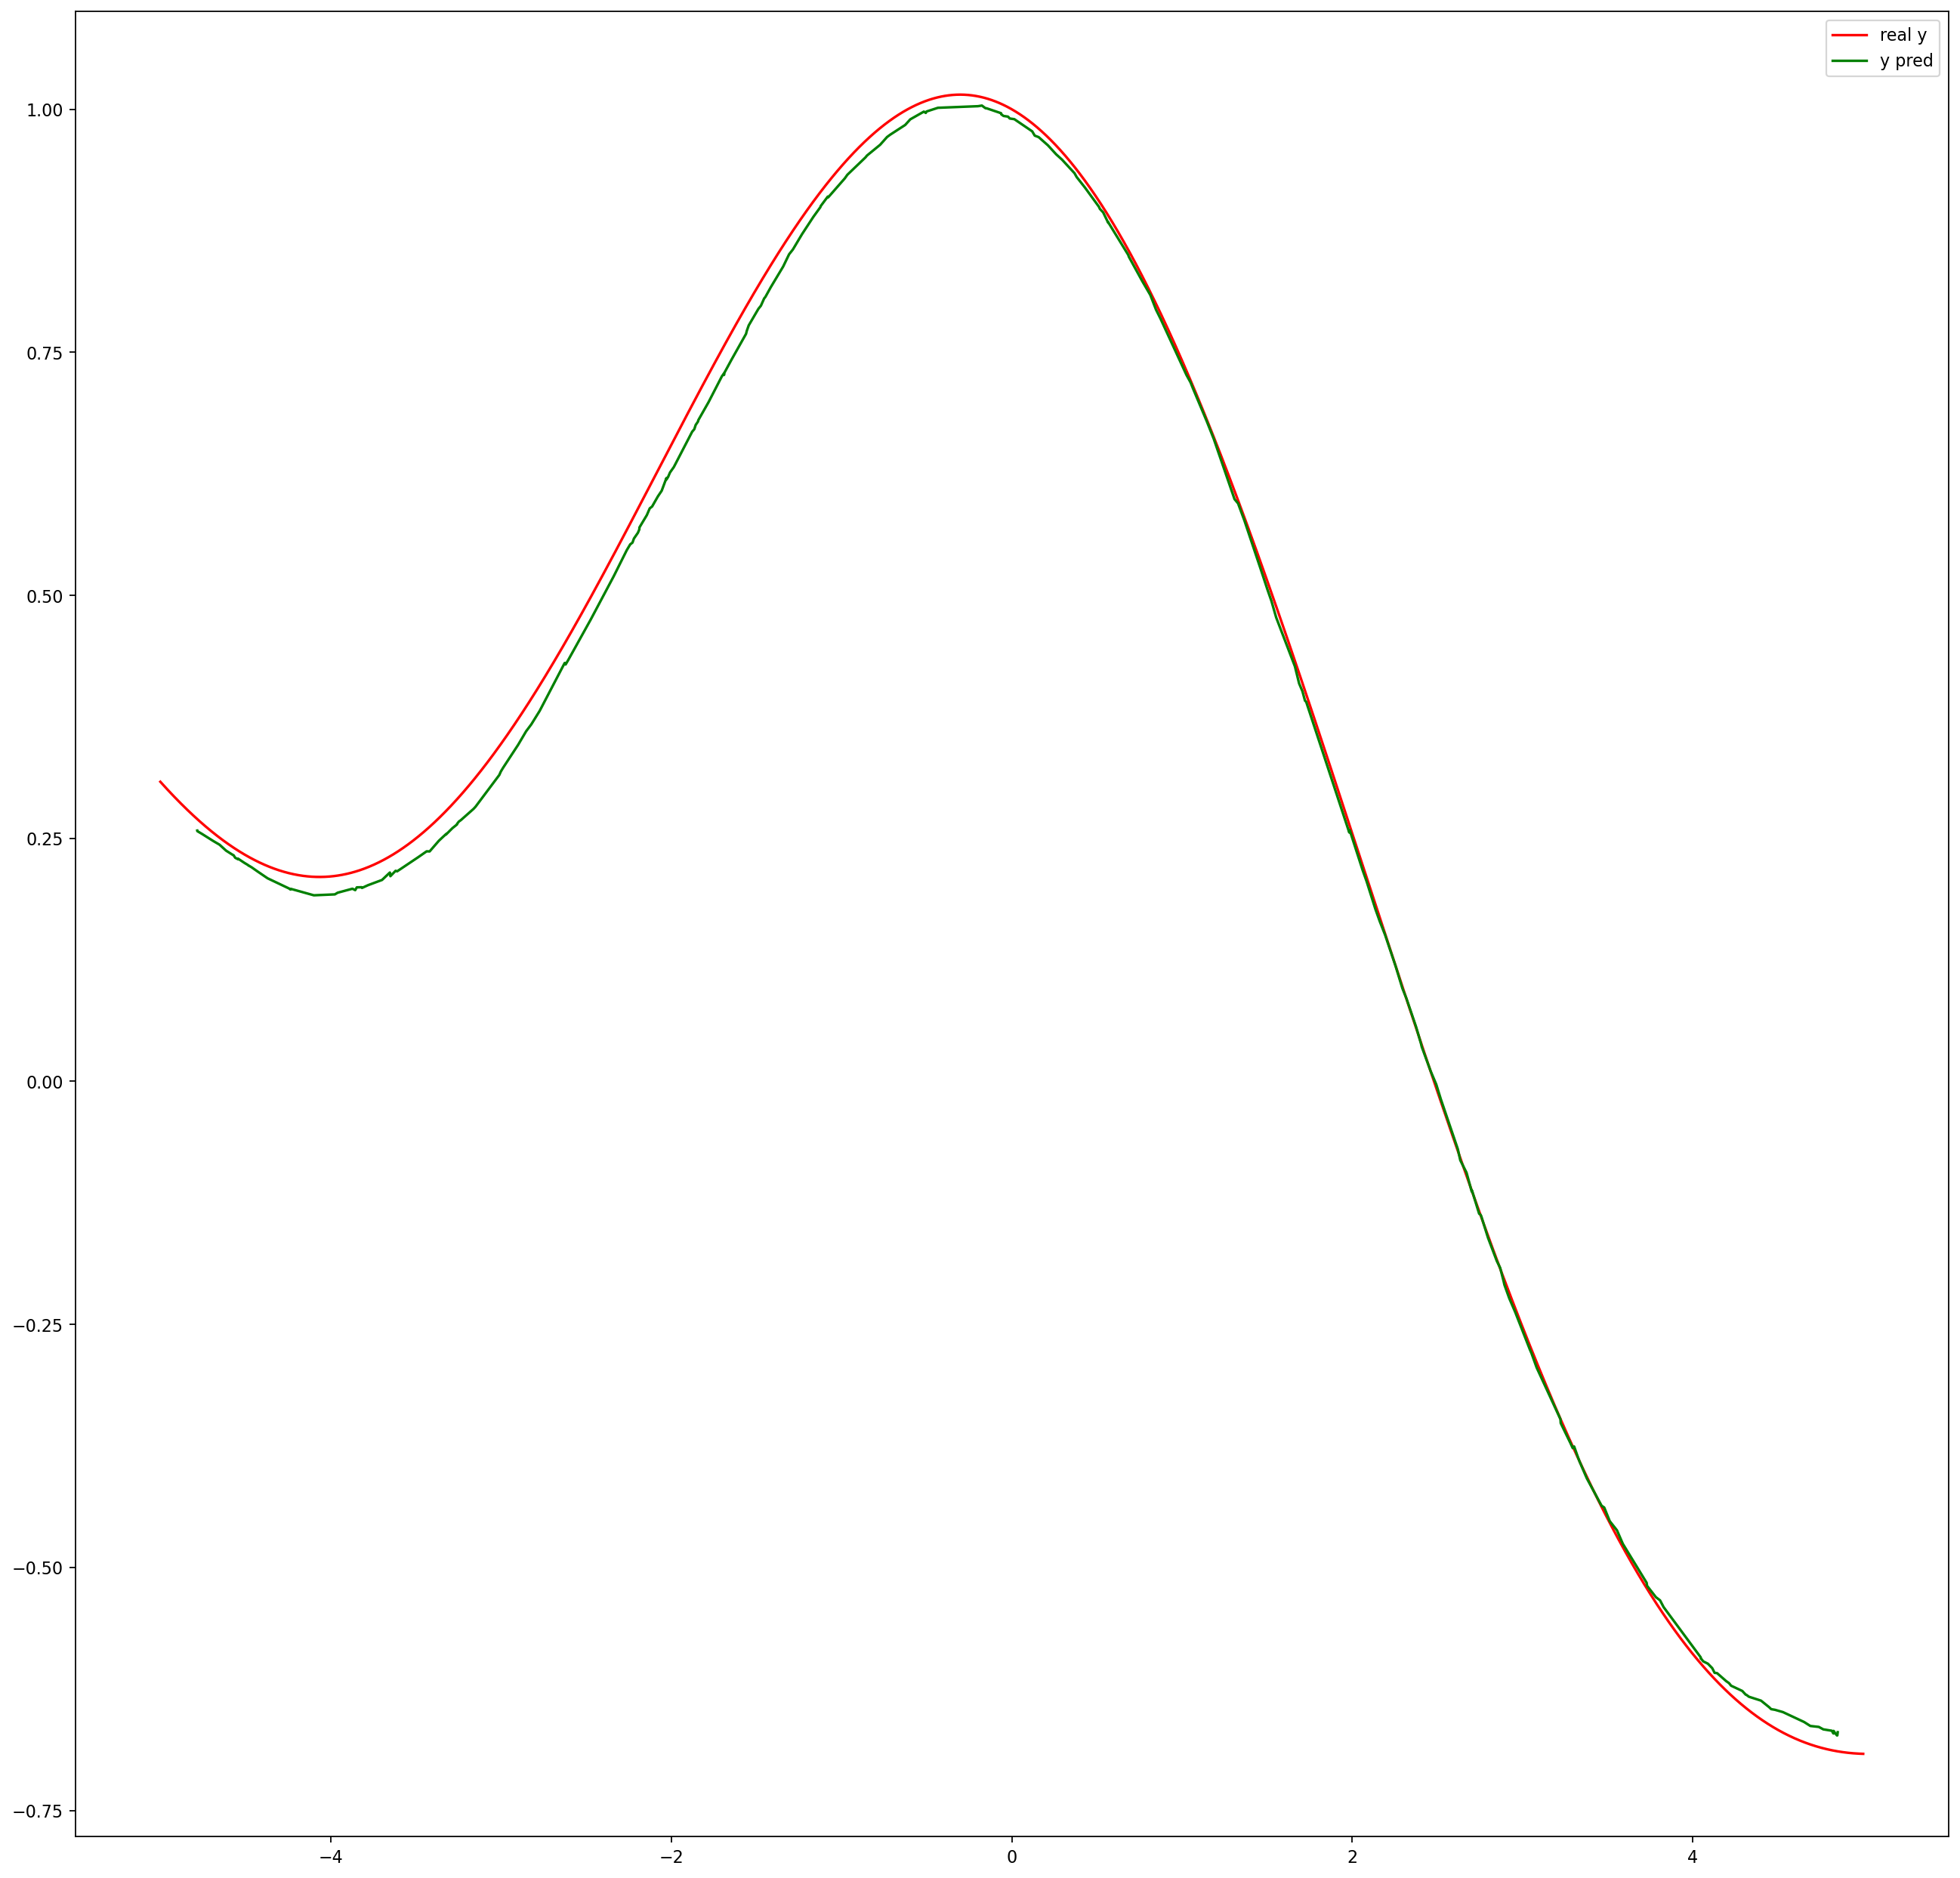

In [19]:
figure(num=None, figsize=(20, 20), dpi=160)

real_x = np.linspace(MIN_X, MAX_X, 3500)
plt.plot(real_x, y(real_x), label='real y', color = 'red')

p = test_pred[:,0].argsort()
plt.plot(test_pred[:,0][p], test_pred[:, 1][p], label='y pred', color = 'green')

plt.legend()
plt.show()